# Analisis Sentimen Review Aplikasi Duolingo
## Persiapan

In [31]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import re
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Embedding, SpatialDropout1D, Dropout, Conv1D, MaxPooling1D, Flatten, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from matplotlib import pyplot as plt


In [8]:
df = pd.read_csv("./duolingo_review.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  9000 non-null   object
 1   rating  9000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 140.8+ KB


In [10]:
print(df.duplicated().sum())
print(df.isna().sum())

1283
review    0
rating    0
dtype: int64


In [11]:
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

## Bersihkan teks

In [13]:
df.sample(5)

,review,rating
626,sweet,5
3449,Duolingo is wonderful app please download and ...,5
4589,this is th best AAP 😍 to learn other languages...,5
7701,It's a great language learning app,5
5331,Great tool to learning a new language,5


In [22]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = re.sub(r'\b\w{1,2}\b', '', text)  # Menghapus kata dengan 1-2 huruf
    text = re.sub(r'[^a-zA-Z\s]', '', text)   # Menghapus karakter non-alfabet
    text = text.lower()                       # Mengubah menjadi huruf kecil
    text = ' '.join([word for word in text.split() if word not in stop_words])  # Hapus stopwords
    return text

df['cleaned_content'] = df['review'].apply(clean_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Raihan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [33]:
df.sample(5)

,review,rating,cleaned_content,label
3961,"to learn other languages, Duolingo tells us ve...",5,learn languages duolingo tells detailed word c...,positif
6245,I love this Duolingo app,5,love duolingo app,positif
8828,The best app for learning i appriciate it,5,best app learning appriciate,positif
2051,It's a fun and interactive way to learn Spanis...,2,fun interactive way learn spanish german given...,negatif
3937,Thay should remove the heart system completely...,1,thay remove heart system completely wander peo...,negatif


In [27]:
# Melabeli data berdasarkan skor
def label_sentiment(score):
    if score >= 4:
        return 'positif'
    elif score == 3:
        return 'netral'
    else:
        return 'negatif'

df['label'] = df['rating'].apply(label_sentiment)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['label'])


## Membuat Model

In [35]:
# Tokenizing dan Padding untuk model LSTM, GRU, CNN, BiLSTM
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df['cleaned_content'])
X_seq = tokenizer.texts_to_sequences(df['cleaned_content'])
X_padded = pad_sequences(X_seq, maxlen=100)

# Membagi data menjadi training dan testing set
X_train_padded, X_test_padded, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)


In [36]:
#Model LSTM
embedding_dim = 100

lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=5000, output_dim=embedding_dim, input_length=100))
lstm_model.add(SpatialDropout1D(0.2))
lstm_model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
lstm_model.add(Dense(3, activation='softmax'))

lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

lstm_history = lstm_model.fit(X_train_padded, y_train, epochs=15, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

_, lstm_accuracy = lstm_model.evaluate(X_test_padded, y_test)
print(f'LSTM Accuracy: {lstm_accuracy * 100:.2f}%')

Epoch 1/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 27s 234ms/step - accuracy: 0.8180 - loss: 0.6031 - val_accuracy: 0.8721 - val_loss: 0.4245
Epoch 2/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 19s 218ms/step - accuracy: 0.8692 - loss: 0.4143 - val_accuracy: 0.8704 - val_loss: 0.3825
Epoch 3/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 17s 223ms/step - accuracy: 0.8934 - loss: 0.3355 - val_accuracy: 0.8777 - val_loss: 0.3768
Epoch 4/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 20s 251ms/step - accuracy: 0.9134 - loss: 0.2711 - val_accuracy: 0.8777 - val_loss: 0.3878
Epoch 5/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 17s 200ms/step - accuracy: 0.9297 - loss: 0.2194 - val_accuracy: 0.8753 - val_loss: 0.4085
Epoch 6/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 17s 223ms/step - accuracy: 0.9332 - loss: 0.2017 - val_accuracy: 0.8737 - val_loss: 0.4293
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8711 - loss: 0.3986
LSTM Accuracy: 86.92%


In [37]:
#Model Gru
gru_model = Sequential()
gru_model.add(Embedding(input_dim=5000, output_dim=embedding_dim, input_length=100))
gru_model.add(SpatialDropout1D(0.2))
gru_model.add(GRU(100, dropout=0.2, recurrent_dropout=0.2))
gru_model.add(Dense(3, activation='softmax'))

gru_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

gru_history = gru_model.fit(X_train_padded, y_train, epochs=15, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

_, gru_accuracy = gru_model.evaluate(X_test_padded, y_test)
print(f'GRU Accuracy: {gru_accuracy * 100:.2f}%')

Epoch 1/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 40s 331ms/step - accuracy: 0.8278 - loss: 0.6581 - val_accuracy: 0.8696 - val_loss: 0.4092
Epoch 2/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 14s 182ms/step - accuracy: 0.8689 - loss: 0.3876 - val_accuracy: 0.8672 - val_loss: 0.3893
Epoch 3/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 14s 180ms/step - accuracy: 0.8852 - loss: 0.3416 - val_accuracy: 0.8745 - val_loss: 0.3833
Epoch 4/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 21s 179ms/step - accuracy: 0.9164 - loss: 0.2666 - val_accuracy: 0.8688 - val_loss: 0.4087
Epoch 5/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 13s 168ms/step - accuracy: 0.9249 - loss: 0.2215 - val_accuracy: 0.8745 - val_loss: 0.4340
Epoch 6/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 13s 164ms/step - accuracy: 0.9438 - loss: 0.1985 - val_accuracy: 0.8761 - val_loss: 0.4709
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8742 - loss: 0.4057
GRU Accuracy: 87.18%


In [38]:
#Model CNN
cnn_model = Sequential()
cnn_model.add(Embedding(input_dim=5000, output_dim=embedding_dim, input_length=100))
cnn_model.add(Conv1D(128, kernel_size=5, activation='relu'))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Flatten())
cnn_model.add(Dense(3, activation='softmax'))

cnn_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

cnn_history = cnn_model.fit(X_train_padded, y_train, epochs=15, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

_, cnn_accuracy = cnn_model.evaluate(X_test_padded, y_test)
print(f'CNN Accuracy: {cnn_accuracy * 100:.2f}%')

Epoch 1/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - accuracy: 0.8141 - loss: 0.5753 - val_accuracy: 0.8769 - val_loss: 0.4197
Epoch 2/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - accuracy: 0.8852 - loss: 0.3865 - val_accuracy: 0.8794 - val_loss: 0.3812
Epoch 3/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.9159 - loss: 0.2943 - val_accuracy: 0.8850 - val_loss: 0.3831
Epoch 4/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - accuracy: 0.9313 - loss: 0.2187 - val_accuracy: 0.8704 - val_loss: 0.4232
Epoch 5/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.9456 - loss: 0.1830 - val_accuracy: 0.8672 - val_loss: 0.4856
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8648 - loss: 0.4197
CNN Accuracy: 86.85%


In [39]:
#Model BiLSTM
bilstm_model = Sequential()
bilstm_model.add(Embedding(input_dim=5000, output_dim=embedding_dim, input_length=100))
bilstm_model.add(SpatialDropout1D(0.2))
bilstm_model.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)))
bilstm_model.add(Dense(3, activation='softmax'))

bilstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

bilstm_history = bilstm_model.fit(X_train_padded, y_train, epochs=15, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

_, bilstm_accuracy = bilstm_model.evaluate(X_test_padded, y_test)
print(f'BiLSTM Accuracy: {bilstm_accuracy * 100:.2f}%')


Epoch 1/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 55s 465ms/step - accuracy: 0.8289 - loss: 0.5758 - val_accuracy: 0.8696 - val_loss: 0.4297
Epoch 2/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 32s 413ms/step - accuracy: 0.8757 - loss: 0.3982 - val_accuracy: 0.8745 - val_loss: 0.3708
Epoch 3/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 34s 432ms/step - accuracy: 0.8954 - loss: 0.3295 - val_accuracy: 0.8785 - val_loss: 0.3653
Epoch 4/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 41s 431ms/step - accuracy: 0.9154 - loss: 0.2588 - val_accuracy: 0.8761 - val_loss: 0.3798
Epoch 5/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 33s 418ms/step - accuracy: 0.9254 - loss: 0.2368 - val_accuracy: 0.8688 - val_loss: 0.4051
Epoch 6/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 34s 435ms/step - accuracy: 0.9381 - loss: 0.2068 - val_accuracy: 0.8737 - val_loss: 0.4363
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.8702 - loss: 0.3865
BiLSTM Accuracy: 87.24%


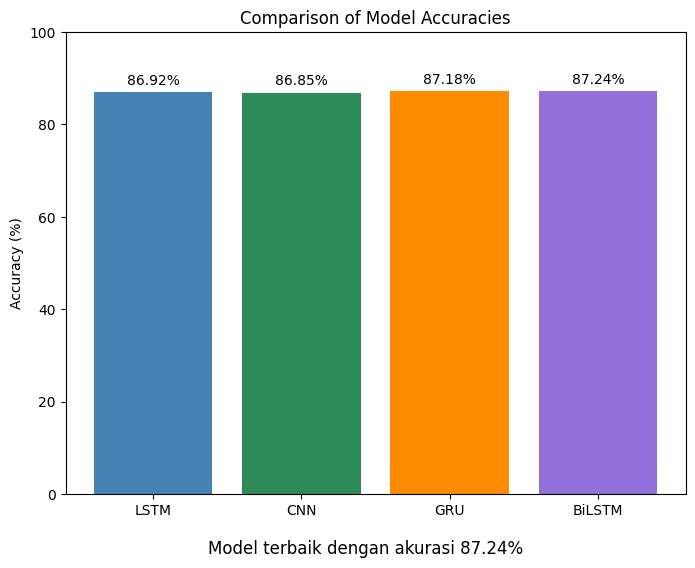

In [40]:

model_names = ['LSTM', 'CNN', 'GRU', 'BiLSTM']
accuracies = [lstm_accuracy * 100, cnn_accuracy * 100, gru_accuracy * 100, bilstm_accuracy * 100]

plt.figure(figsize=(8, 6))
bars = plt.bar(model_names, accuracies, color=['steelblue', 'seagreen', 'darkorange', 'mediumpurple'])
plt.ylim(0, 100)
plt.ylabel('Accuracy (%)')
plt.title('Comparison of Model Accuracies')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 1, f'{yval:.2f}%', ha='center', va='bottom')

best_accuracy = max(lstm_accuracy, cnn_accuracy, gru_accuracy, bilstm_accuracy)
if best_accuracy >= 0.85:
    best_message = f"Model terbaik dengan akurasi {best_accuracy * 100:.2f}%"
else:
    best_message = "Tidak ada model yang mencapai akurasi 85%"

plt.figtext(0.5, 0.01, best_message, wrap=True, horizontalalignment='center', fontsize=12)
plt.show()


In [41]:
models = {
    "LSTM": (lstm_model, lstm_accuracy),
    "CNN": (cnn_model, cnn_accuracy),
    "GRU": (gru_model, gru_accuracy),
    "BiLSTM": (bilstm_model, bilstm_accuracy)
}

best_model_name, (best_model, best_acc) = max(models.items(), key=lambda item: item[1][1])

best_model.save(f"best_model_{best_model_name}.h5")
print(f"Best model adalah {best_model_name} with accuracy {best_acc * 100:.2f}%. Saved as best_model_{best_model_name}.h5")


Best model adalah BiLSTM with accuracy 87.24%. Saved as best_model_BiLSTM.h5
